In [1]:
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt
import ruamel.yaml as yaml
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

from utils.dataprep import load_emb_pickled

In [2]:
plt.style.use('bmh')

In [3]:
SPLITTER = re.compile(r"\s+")


def load_data_classes(dataset):
    metadata, embeddings = load_emb_pickled(dataset)
    filenames = metadata.get("fnames")
    categories = metadata.get("categories")
    classes = metadata.get("classes")
    class_idx = metadata.get("class_idx")
    class_names = metadata.get("class_names")
    return class_idx, class_names


def prepare_data_frame(results_file):
    df = pd.read_csv(results_file)
    df.loc[:, "target_image"] = df.loc[:, "images"].apply(lambda x: int(SPLITTER.split(x.strip("[] "))[0]))
#     df.loc[:, "target_category"] = df.apply(lambda x: categories[x.loc["target_image"]], axis=1)
#     df.loc[:, "target_class"] = df.apply(lambda x: classes[x.loc["target_image"]], axis=1)
    return df


def prepare_symbol_matrix(df, class_idx, n_symbols, negative_weights=0.05, filter_empty=True):
    total_images = len(class_idx)
    data = np.zeros([total_images, n_symbols])
    
    for k, row in df.iterrows():
        target, *other = SPLITTER.split(row["images"].strip("[] "))
        data[int(target), row["symbol"]] += 1
        for img in other:
            img = int(img)
            data[img, row["symbol"]] -= negative_weights
    
    if not filter_empty:
        return data, class_idx
    notnan = np.where((data != 0).any(axis=1))
    data_notnan = data[notnan, :][0]
    return data_notnan, class_idx[notnan]
    
    
def load_settings(filename):
    with open(filename) as f:
        settings = yaml.load(f)
    return settings

In [5]:
dataset = "data/big/mcrae-wordnet-vgg16.32bit"
class_idx, class_names = load_data_classes(dataset)

Loading features from data/big/mcrae-wordnet-vgg16.32bit.npy.gz
Loading metadata from data/big/mcrae-wordnet-vgg16.32bit.meta.pkl
4 categories found.


In [19]:
name = "e3-4img"
models_path = "models"
results_file = "10000games4i.results.csv"
settings_file = "settings.yml"
model_folder = "e3-4images-210523-022405"

settings = load_settings(os.path.join(models_path, model_folder, settings_file))
df = prepare_data_frame(os.path.join(models_path, model_folder, results_file))
data, cls = prepare_symbol_matrix(df, class_idx, settings["vocabulary_size"], negative_weights=0.5)

<ipython-input-6-c9a4aa826beb>:42: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  settings = yaml.load(f)


In [8]:
tsne = TSNE(n_components=2, perplexity=18)
tsne_out = tsne.fit_transform(data)

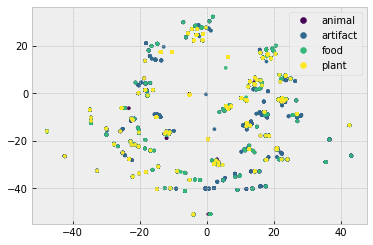

In [20]:
scatter = plt.scatter(*tsne_out.T, c=cls, s=10)
plt.legend(handles=scatter.legend_elements()[0], labels=list(class_names))
plt.savefig(f"{name}-tsne.png", dpi=200)

In [16]:
umap_out = UMAP(n_components=2, n_neighbors=80, min_dist=0.5).fit_transform(data)

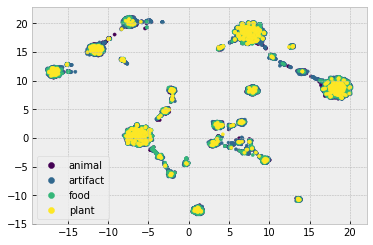

In [17]:
scatter = plt.scatter(*umap_out.T, c=cls, s=10)
plt.legend(handles=scatter.legend_elements()[0], labels=list(class_names))

In [7]:
def reduce_and_plot(
    models_base_path, model_folder, class_idx, class_names, 
    negative_weights=0.5,
    results_file="10000games.results.csv", output_name="10000games.results", settings_file = "settings.yml",
    tsne_kwargs=None, umap_kwargs=None
):
    model_path = os.path.join(models_base_path, model_folder)
    
    print(f">>>> Processing {model_path} ...")
    print("Preparing matrix... ", end="")
    settings = load_settings(os.path.join(model_path, settings_file))
    df = prepare_data_frame(os.path.join(model_path, results_file))
    data, cls = prepare_symbol_matrix(
        df, class_idx, settings["vocabulary_size"], 
        negative_weights=negative_weights
    )
    
    print("Computing tSNE... ", end="")
    if tsne_kwargs is None:
        tsne_kwargs = {
            "perplexity": 30
        }
    tsne = TSNE(n_components=2, **tsne_kwargs)
    tsne_out = tsne.fit_transform(data)
    scatter = plt.scatter(*tsne_out.T, c=cls, s=10)
    
    print("Saving results", end="")
    np.save(
        os.path.join(model_path, f"{output_name}.tsne.npy"), 
        tsne_out
    )
    plt.legend(handles=scatter.legend_elements()[0], labels=list(class_names))
    
    print(", plot... ", end="")
    plt.savefig(
        os.path.join(model_path, f"{output_name}.tsne.png"), 
        dpi=200
    )
    plt.clf()
    
    print("Computing UMAP... ", end="")
    if umap_kwargs is None:
        umap_kwargs = { 
            "n_neighbors": 30
        }
    umap_out = UMAP(n_components=2, **umap_kwargs).fit_transform(data)
    scatter = plt.scatter(*umap_out.T, c=cls, s=10)
    
    print("Saving results", end="")
    np.save(
        os.path.join(model_path, f"{output_name}.umap.npy"), 
        umap_out
    )
    plt.legend(handles=scatter.legend_elements()[0], labels=list(class_names))
    
    print(", plot... ", end="")
    plt.savefig(
        os.path.join(model_path, f"{output_name}.umap.png"), 
        dpi=200
    )
    plt.clf()
    
    print("DONE")

In [9]:
models_base_path = "best_models"
folders = """
e1-explore-temp-210519-222000
e3-4images-210523-022405
e3-6images-210523-031950
e4-switch-2img-210523-142302
e4-switch-2img-210524-124621
e4-switch-4img-210523-154352
e4-switch-4img-210524-140539
e4-switch-6img-210524-200612
e4-switch-6img-210524-204656
""".strip().split("\n")

for folder in folders:
    reduce_and_plot(
        models_base_path, folder, class_idx, class_names, 
        negative_weights=0.5,
        results_file="10000games-same.results.csv", output_name="10000games-same.results",
        tsne_kwargs=None, umap_kwargs=None
    )


>>>> Processing best_models/e1-explore-temp-210519-222000 ...
Preparing matrix... 

<ipython-input-3-c9a4aa826beb>:42: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  settings = yaml.load(f)


Computing tSNE... Saving results, plot... Computing UMAP... Saving results, plot... DONE
>>>> Processing best_models/e3-4images-210523-022405 ...
Preparing matrix... 

<ipython-input-3-c9a4aa826beb>:42: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  settings = yaml.load(f)


Computing tSNE... Saving results, plot... Computing UMAP... Saving results, plot... DONE
>>>> Processing best_models/e3-6images-210523-031950 ...
Preparing matrix... 

<ipython-input-3-c9a4aa826beb>:42: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  settings = yaml.load(f)


Computing tSNE... Saving results, plot... Computing UMAP... Saving results, plot... DONE
>>>> Processing best_models/e4-switch-2img-210523-142302 ...
Preparing matrix... 

<ipython-input-3-c9a4aa826beb>:42: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  settings = yaml.load(f)


Computing tSNE... Saving results, plot... Computing UMAP... Saving results, plot... DONE
>>>> Processing best_models/e4-switch-2img-210524-124621 ...
Preparing matrix... 

<ipython-input-3-c9a4aa826beb>:42: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  settings = yaml.load(f)


Computing tSNE... Saving results, plot... Computing UMAP... Saving results, plot... DONE
>>>> Processing best_models/e4-switch-4img-210523-154352 ...
Preparing matrix... 

<ipython-input-3-c9a4aa826beb>:42: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  settings = yaml.load(f)


Computing tSNE... Saving results, plot... Computing UMAP... Saving results, plot... DONE
>>>> Processing best_models/e4-switch-4img-210524-140539 ...
Preparing matrix... 

<ipython-input-3-c9a4aa826beb>:42: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  settings = yaml.load(f)


Computing tSNE... Saving results, plot... Computing UMAP... Saving results, plot... DONE
>>>> Processing best_models/e4-switch-6img-210524-200612 ...
Preparing matrix... 

<ipython-input-3-c9a4aa826beb>:42: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  settings = yaml.load(f)


Computing tSNE... Saving results, plot... Computing UMAP... Saving results, plot... DONE
>>>> Processing best_models/e4-switch-6img-210524-204656 ...
Preparing matrix... 

<ipython-input-3-c9a4aa826beb>:42: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  settings = yaml.load(f)


Computing tSNE... Saving results, plot... Computing UMAP... Saving results, plot... DONE


<Figure size 432x288 with 0 Axes>

In [15]:
def plot_saved(models_base_path, model_folders, class_idx, class_names, file_name, labels):
    fig = plt.figure()
#     plt.tight_layout()
    fig.set_size_inches(12, 12)
    grid = fig.add_gridspec(*np.asarray(model_folders).shape, hspace=0.03, wspace=0.03)
    subplots = grid.subplots(sharex='col', sharey='row')
    for folder, label, ax in zip(np.ravel(model_folders), np.ravel(labels), np.ravel(subplots)):
        model_path = os.path.join(models_base_path, folder)
        
        # need to relfilter this because I didn't save `cls`
        settings = load_settings(os.path.join(model_path, "settings.yml"))
        df = prepare_data_frame(os.path.join(model_path, "10000games-same.results.csv"))
        data, cls = prepare_symbol_matrix(
            df, class_idx, settings["vocabulary_size"], 
            negative_weights=0.5
        )
        
        scatter_path = os.path.join(models_base_path, folder, file_name)
        data = np.load(scatter_path)
        scatter = ax.scatter(*data.T, c=cls, s=10)
        ax.text(.5, .95, label,
            horizontalalignment='center',
            transform=ax.transAxes
        )
    plt.legend(handles=scatter.legend_elements()[0], labels=list(class_names), loc='lower right')

<ipython-input-3-c9a4aa826beb>:42: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  settings = yaml.load(f)


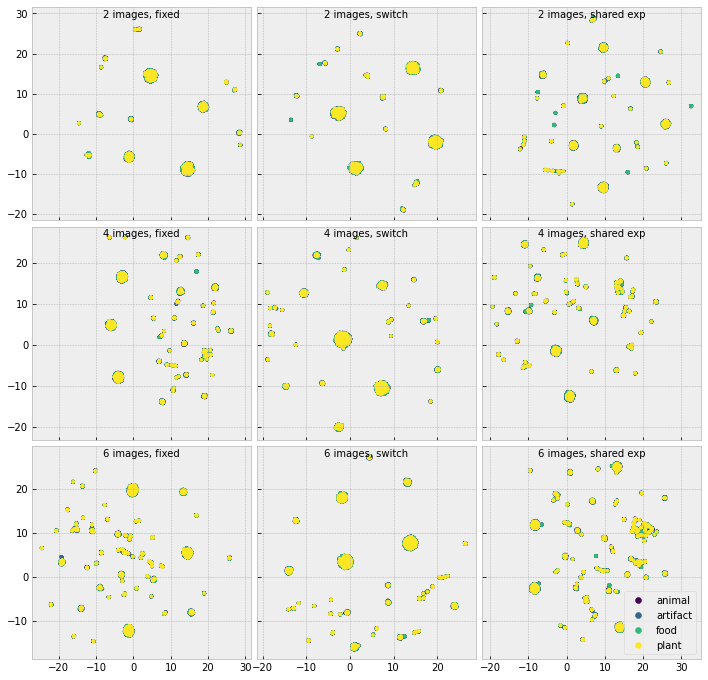

In [16]:
models_base_path = "best_models"
folders = """
e1-explore-temp-210519-222000
e4-switch-2img-210523-142302
e4-switch-2img-210524-124621

e3-4images-210523-022405
e4-switch-4img-210523-154352
e4-switch-4img-210524-140539

e3-6images-210523-031950
e4-switch-6img-210524-200612
e4-switch-6img-210524-204656
""".strip()
folders = [
    group.split("\n")
    for group in folders.split("\n\n")
]

labels = """
2 images, fixed
2 images, switch
2 images, shared exp

4 images, fixed
4 images, switch
4 images, shared exp

6 images, fixed
6 images, switch
6 images, shared exp
""".strip()
labels = [
    group.split("\n")
    for group in labels.split("\n\n")
]
plot_saved(models_base_path, folders, class_idx, class_names, "10000games-same.results.umap.npy", labels)

plt.savefig(os.path.join(models_base_path, f"10000games-same.umap.png"), dpi=200, bbox_inches="tight")